# San Diego Tracts

This dataset contains an extract of a set of variables from the 2017 ACS Census Tracts for the San Diego (CA) metropolitan area.

In [1]:
!pip install cenpy
!pip install python-Levenshtein

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.4/131.4 kB 2.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.1 MB/s eta 0:00:0000:0100:01


In [2]:
pip install contextily

Note: you may need to restart the kernel to use updated packages.


In [33]:
import contextily
import geopandas
import cenpy
import matplotlib.pyplot as plt
acs = cenpy.products.ACS(2017)

## Download Data

- Set variables to download

In [34]:
vars_to_download = {
    "B25077_001E": "median_house_value",  # Median house value
    "B02001_002E": "total_pop_white",     # Total white population
    "B01003_001E": "total_pop",           # Total population
    "B25003_003E": "total_rented",        # Total rented occupied
    "B25001_001E": "total_housing_units", # Total housing units
    "B09019_006E": "hh_female",           # Female households
    "B09019_001E": "hh_total",            # Total households
    "B15003_002E": "total_bachelor",      # Total No schooling completed
    "B25018_001E": "median_no_rooms",     # Median number of rooms
    "B19083_001E": "income_gini",         # Gini index of income inequality
    "B01002_001E": "median_age",          # Median age
    "B08303_001E": "tt_work",              # Aggregate travel time to work
    "B19013_001E": "median_hh_income"     # Median household income
}
vars_to_download_l = list(vars_to_download.keys())

- Download geometries and attributes

In [35]:
%%time
db = acs.from_msa("San Diego, CA",
                  level="tract",
                  variables=vars_to_download_l
                 )

CPU times: user 1.28 s, sys: 149 ms, total: 1.43 s
Wall time: 1min 19s


/Users/marta/opt/anaconda3/lib/python3.9/site-packages/cenpy/products.py:748: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  return self._from_name(


## Metadata

We create a DataFrame that contains information about the variables to be downloaded, including the variable name (stored as "var_id"), a short name (stored as "short_name"), the label of the variable, and its associated concept. This information allows us to keep track of what each variable represents.

In [36]:
var_names = acs.variables\
               .reindex(vars_to_download)\
               [["label", "concept"]]\
               .reset_index()\
               .rename(columns={"index": "var_id"})
var_names["short_name"] = var_names["var_id"].map(vars_to_download)

In [37]:
var_names

,var_id,label,concept,short_name
0,B25077_001E,Estimate!!Median value (dollars),MEDIAN VALUE (DOLLARS),median_house_value
1,B02001_002E,Estimate!!Total!!White alone,RACE,total_pop_white
2,B01003_001E,Estimate!!Total,TOTAL POPULATION,total_pop
3,B25003_003E,Estimate!!Total!!Renter occupied,TENURE,total_rented
4,B25001_001E,Estimate!!Total,HOUSING UNITS,total_housing_units
5,B09019_006E,Estimate!!Total!!In households!!In family hous...,HOUSEHOLD TYPE (INCLUDING LIVING ALONE) BY REL...,hh_female
6,B09019_001E,Estimate!!Total,HOUSEHOLD TYPE (INCLUDING LIVING ALONE) BY REL...,hh_total
7,B15003_002E,Estimate!!Total!!No schooling completed,EDUCATIONAL ATTAINMENT FOR THE POPULATION 25 Y...,total_bachelor
8,B25018_001E,Estimate!!Median number of rooms,MEDIAN NUMBER OF ROOMS,median_no_rooms
9,B19083_001E,Estimate!!Gini Index,GINI INDEX OF INCOME INEQUALITY,income_gini


## Process data

While the ACS comes with a large number of attributes, we are not limited to the original variables at hand; we
can construct additional variables. This is particularly useful when
we want to compare areas that are not very similar in some structural
characteristic, such as area or population. For example, a quick look into the
variable names shows most variables are counts. For tracts of different sizes,
these variables will mainly reflect their overall population, rather than provide direct information
about the variables itself. To get around this, we will cast many of these count variables to rates,
and use them in addition to a subset of the original variables. 

- Replace missing values with columns mean

In [38]:
filler = lambda col: col.fillna(col.mean())
db.loc[:, vars_to_download] = db.loc[:, vars_to_download]\
                                .apply(filler)

/var/folders/6f/phk5mdmd46z3r251brl5bj440000gn/T/ipykernel_5207/1149192865.py:2: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  db.loc[:, vars_to_download] = db.loc[:, vars_to_download]\
/var/folders/6f/phk5mdmd46z3r251brl5bj440000gn/T/ipykernel_5207/1149192865.py:2: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  db.loc[:, vars_to_download] = db.loc[:, vars_to_download]\


- Replace variable codes with short names

In [39]:
db = db.rename(columns=vars_to_download)

- Calculate area in Sq.Km (we use the [Conus Albers](http://epsg.io/5070) CRS)

In [40]:
db["area_sqkm"] = db.to_crs(epsg=5070).area / 1e6

- Percentage of renter occupied units

In [41]:
db["pct_rented"] = db["total_rented"] / \
                  (db["total_housing_units"] + \
                   (db["total_housing_units"]==0) * 1
                  )

- Percentage of female households

In [42]:
db["pct_hh_female"] = db["hh_female"] / \
                  (db["hh_total"] + \
                   (db["hh_total"]==0) * 1
                  )

- Percentage without completing Schooling

In [43]:
db["pct_bachelor"] = db["total_bachelor"] / \
                  (db["total_pop"] + \
                   (db["total_pop"]==0) * 1
                  )

- Percentage of white population

In [44]:
db["pct_white"] = db["total_pop_white"] / \
                  (db["total_pop"] + \
                   (db["total_pop"]==0) * 1
                  )

- Generate indicator for subset of contiguous 30 tracts

In [45]:
tract_geoids = [
     '06073000100',
     '06073000201',
     '06073000202',
     '06073000300',
     '06073000400',
     '06073000500',
     '06073000600',
     '06073000700',
     '06073000800',
     '06073000900',
     '06073001000',
     '06073001100',
     '06073001200',
     '06073001300',
     '06073001400',
     '06073001500',
     '06073001600',
     '06073001700',
     '06073001800',
     '06073001900',
     '06073002001',
     '06073002002',
     '06073002100',
     '06073002201',
     '06073002202',
     '06073002301',
     '06073002302',
     '06073002401',
     '06073002402',
     '06073002501'
]
db["sub_30"] = False
db.loc[db["GEOID"].isin(tract_geoids), "sub_30"] = True

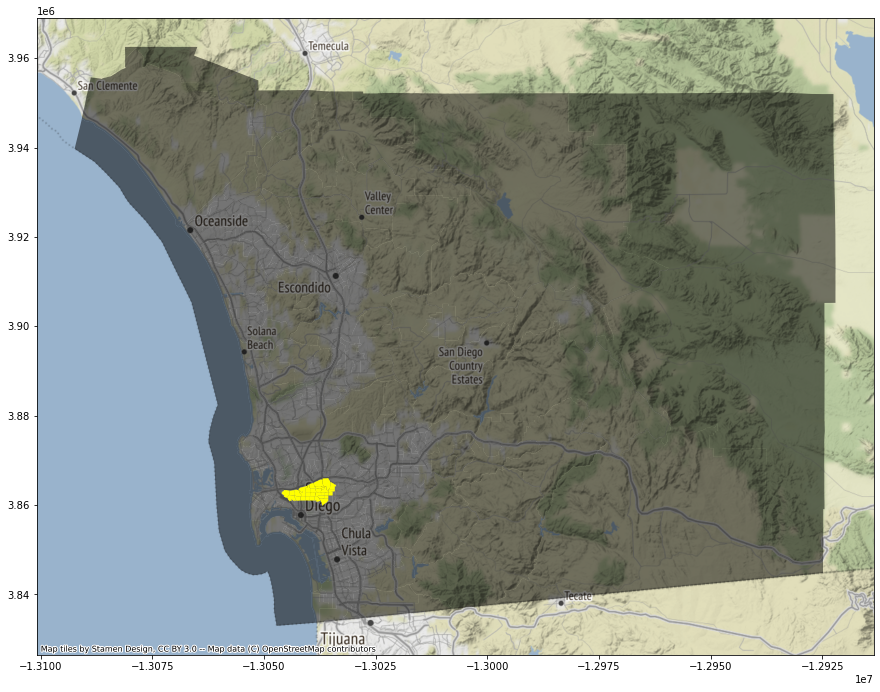

In [46]:
ax = db.plot(figsize=(15, 15),alpha=0.5, color="k")
db[db["sub_30"]].plot(ax=ax, color="yellow")
contextily.add_basemap(ax, crs=db.crs);



In [30]:
db

,GEOID,geometry,median_age,total_pop,total_pop_white,tt_work,hh_total,hh_female,total_bachelor,median_hh_income,...,NAME,state,county,tract,sub_30,area_sqkm,pct_rented,pct_hh_female,pct_bachelor,pct_white
0,06073007701,"POLYGON ((-13052014.930 3867748.530, -13051974...",31.9,4074.0,3737.0,2243.0,4074.0,301.0,0.0,73019.0,...,"Census Tract 77.01, San Diego County, California",06,073,007701,False,0.568635,0.626149,0.073883,0.000000,0.917280
1,06073008002,"POLYGON ((-13052206.510 3870188.930, -13052193...",37.0,2968.0,2677.0,1558.0,2968.0,296.0,0.0,109224.0,...,"Census Tract 80.02, San Diego County, California",06,073,008002,False,1.091591,0.308863,0.099730,0.000000,0.901954
2,06073007903,"POLYGON ((-13051964.720 3869215.200, -13051923...",30.2,4660.0,4079.0,3100.0,4660.0,425.0,0.0,59781.0,...,"Census Tract 79.03, San Diego County, California",06,073,007903,False,0.757675,0.663439,0.091202,0.000000,0.875322
3,06073008364,"POLYGON ((-13050548.180 3875343.810, -13050522...",30.1,5811.0,3135.0,3169.0,5811.0,448.0,0.0,71629.0,...,"Census Tract 83.64, San Diego County, California",06,073,008364,False,0.989247,0.720193,0.077095,0.000000,0.539494
4,06073008305,"POLYGON ((-13051530.240 3879241.240, -13051529...",27.1,2002.0,1053.0,879.0,2002.0,152.0,0.0,37863.0,...,"Census Tract 83.05, San Diego County, California",06,073,008305,False,4.457771,0.866258,0.075924,0.000000,0.525974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
623,06073020403,"POLYGON ((-13035010.540 3909697.920, -13034972...",35.9,4071.0,2805.0,1955.0,4071.0,350.0,112.0,83750.0,...,"Census Tract 204.03, San Diego County, California",06,073,020403,False,2.920103,0.273752,0.085974,0.027512,0.689020
624,06073017015,"POLYGON ((-13033181.790 3898518.810, -13033173...",41.7,8107.0,5286.0,3881.0,8107.0,1164.0,14.0,90034.0,...,"Census Tract 170.15, San Diego County, California",06,073,017015,False,4.768467,0.326335,0.143580,0.001727,0.652029
625,06073020211,"POLYGON ((-13032500.400 3913774.570, -13032459...",30.2,7005.0,5014.0,3195.0,7005.0,684.0,258.0,42007.0,...,"Census Tract 202.11, San Diego County, California",06,073,020211,False,1.586864,0.678791,0.097645,0.036831,0.715774
626,06073020109,"POLYGON ((-13033438.040 3914199.330, -13033420...",33.7,5622.0,4550.0,2809.0,5622.0,531.0,129.0,85278.0,...,"Census Tract 201.09, San Diego County, California",06,073,020109,False,1.549637,0.329268,0.094450,0.022946,0.809321


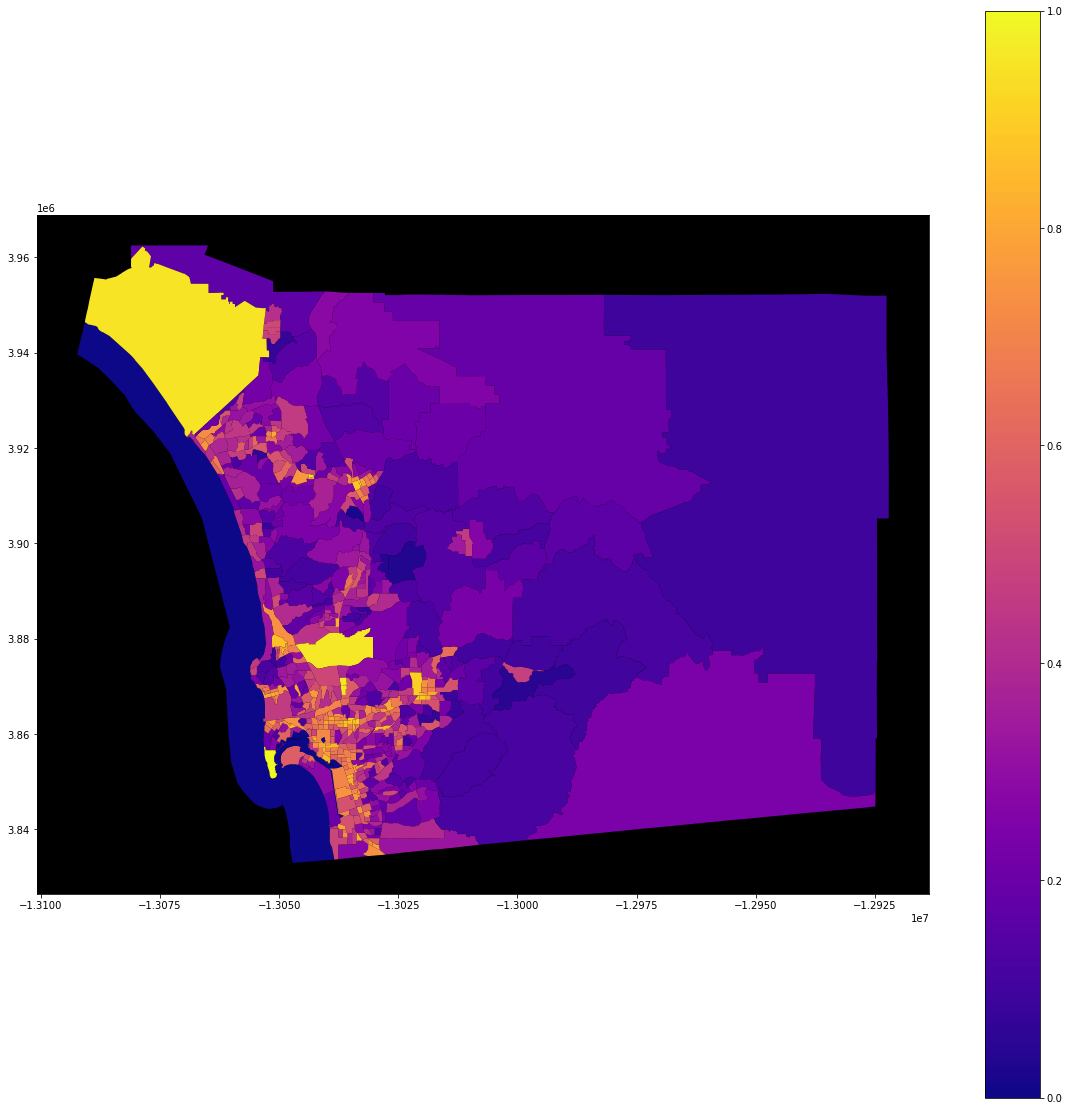

In [58]:
f, ax = plt.subplots(1,1,figsize=(20,20))
db.plot('pct_rented', ax=ax, cmap='plasma',legend=True)
ax.set_facecolor('k')
plt.savefig('sandiego_rented_map.png')

In [64]:
min(db['pct_rented'])

0.0

In [92]:
db['pct_rented'].max()

1.0

In [93]:
n1, bins1 = np.histogram(db['pct_rented'],density='True')

In [94]:
n1

array([0.30254777, 1.56050955, 1.62420382, 1.44904459, 1.36942675,
       1.11464968, 1.05095541, 0.97133758, 0.44585987, 0.11146497])

In [95]:
bins1[:-1]

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [96]:
sum(n1*0.1)

1.0

Text(0, 0.5, 'PDF(F_rented)')

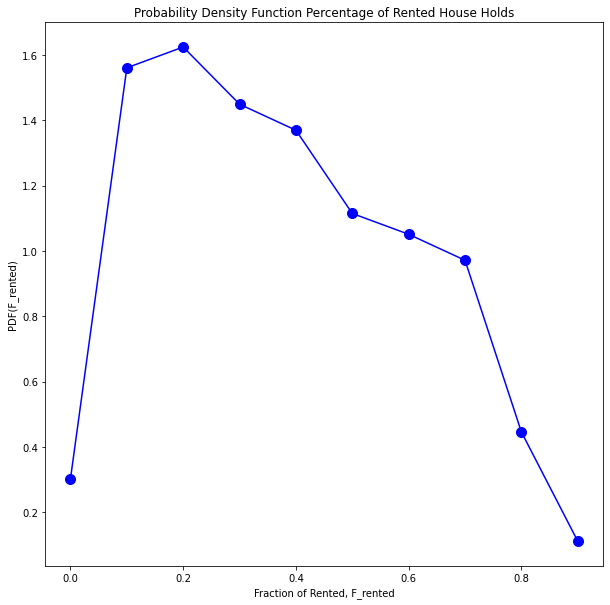

In [107]:
plt.figure(figsize=(10,10))
plt.plot(bins1[:-1],n1,'bo-', markersize=10) 
plt.title('Probability Density Function Percentage of Rented House Holds')
plt.xlabel('Fraction of Rented, F_rented')
plt.ylabel('PDF(F_rented)')

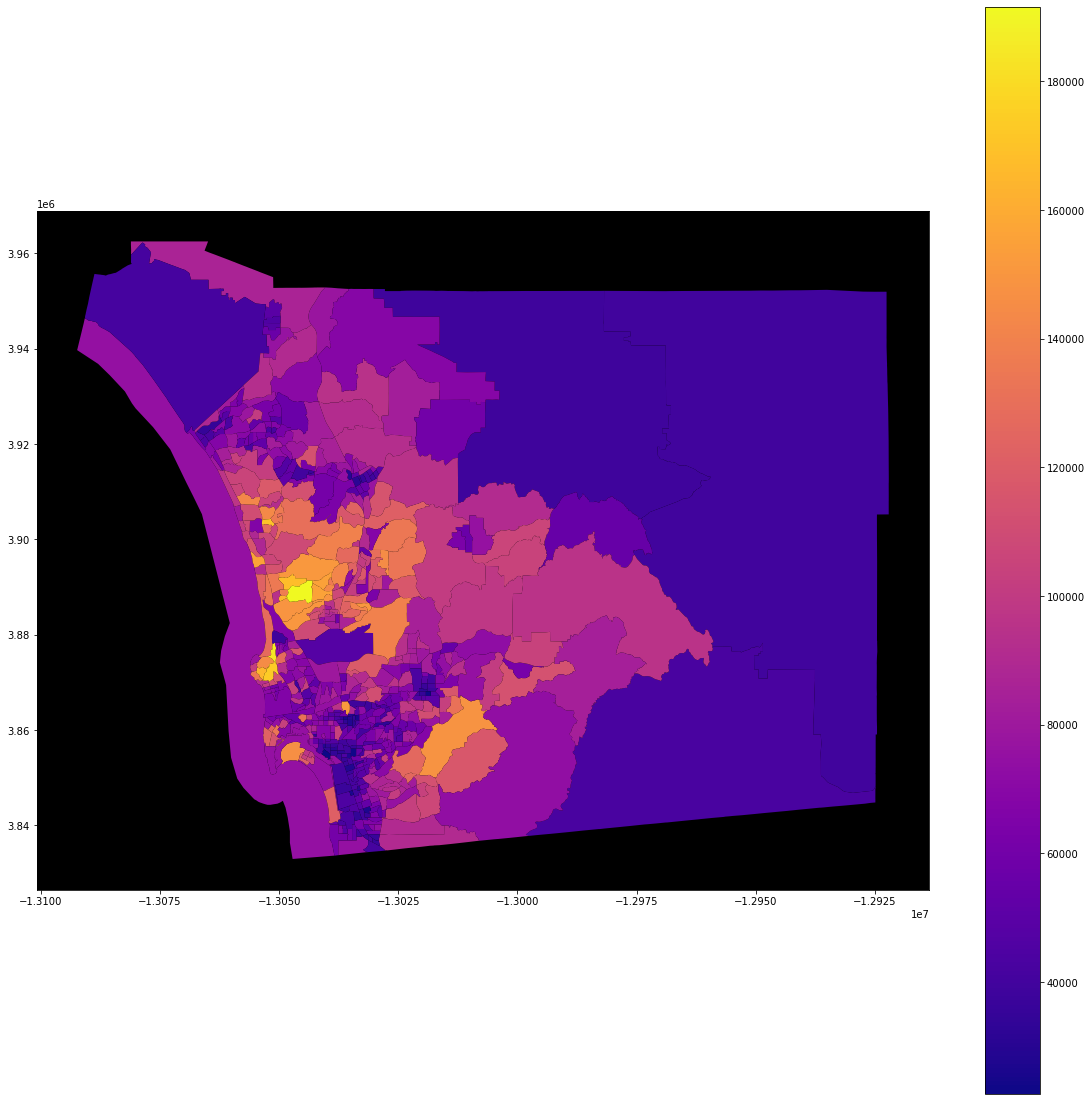

In [59]:
f, ax = plt.subplots(1,1,figsize=(20,20))
db.plot('median_hh_income', ax=ax, cmap='plasma',legend=True)
ax.set_facecolor('k')
plt.savefig('sandiego_median_hh_income.png')

In [99]:
n2, bins2 = np.histogram(db['median_hh_income'],density='True')

In [100]:
n2

array([5.65240086e-06, 1.20584552e-05, 1.39425888e-05, 1.14932151e-05,
       7.25391444e-06, 4.14509396e-06, 2.26096034e-06, 1.69572026e-06,
       4.71033405e-07, 1.88413362e-07])

In [101]:
bins2

array([ 22614. ,  39516.8,  56419.6,  73322.4,  90225.2, 107128. ,
       124030.8, 140933.6, 157836.4, 174739.2, 191642. ])

In [111]:
sum(n2*(bins2[1]-bins2[0]))

1.0000000000000002

Text(0, 0.5, 'PDF(Med_HH_Income)')

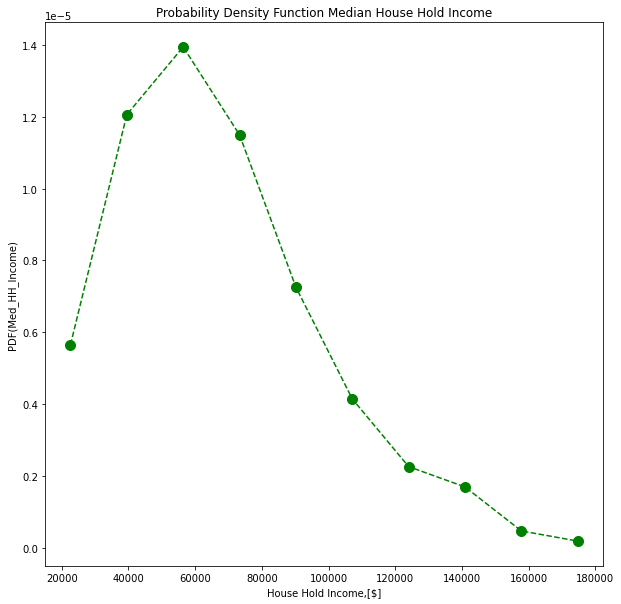

In [108]:
plt.figure(figsize=(10,10))
plt.plot(bins2[:-1],n2,'go--', markersize=10)
plt.title('Probability Density Function Median House Hold Income')
plt.xlabel('House Hold Income,[$]')
plt.ylabel('PDF(Med_HH_Income)')

## Write Out

In [25]:
db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 628 entries, 0 to 627
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   GEOID                628 non-null    object  
 1   geometry             628 non-null    geometry
 2   median_age           628 non-null    float64 
 3   total_pop            628 non-null    float64 
 4   total_pop_white      628 non-null    float64 
 5   tt_work              628 non-null    float64 
 6   hh_total             628 non-null    float64 
 7   hh_female            628 non-null    float64 
 8   total_bachelor       628 non-null    float64 
 9   median_hh_income     628 non-null    float64 
 10  income_gini          628 non-null    float64 
 11  total_housing_units  628 non-null    float64 
 12  total_rented         628 non-null    float64 
 13  median_no_rooms      628 non-null    float64 
 14  median_house_value   628 non-null    float64 
 15  NAME           

- Dataset

In [11]:
! rm -f sandiego_tracts.gpkg
db.to_file("sandiego_tracts.gpkg", driver="GPKG")

/Users/marta/opt/anaconda3/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


- Metadata

In [26]:
! rm -f sandiego_tracts_varnames.json
var_names.to_json("sandiego_tracts_varnames.json")

See: https://www.gis-blog.com/geopackage-vs-shapefile/

GeoPackage is an open, portable, and compact format for transferring geospatial information.

In [29]:
len(db)

628

In [50]:
int(4.5)

4

In [57]:
round(4.6)

5